In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import seaborn
from scipy.stats import sem
import pickle as pkl
import src.SessionNavigator as SessionNavigator
import src.SessionProcessor as SessionProcessor
from sklearn.svm import LinearSVC
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

c:\Users\Demogorgon\anaconda3\envs\Python37\lib\site-packages\allensdk\brain_observatory\comparison_utils.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
# Decoding accuracy vs time for whole and separated trains
CV_COUNT = 10

def dict_to_array(dictionary, cv_count):
    arr = np.zeros((len(dictionary), cv_count))
    for key, value in dictionary.items():
        arr[key] = value
    return arr

In [4]:
data_root = "C:/Users/Demogorgon/Documents/College/Marcus/Boston University PhD/Ocker Lab"
manifest_path = f"{data_root}/AllenSDK_Data/manifest.json"
save_path = f"{data_root}/correlations_and_bursts/data"

navigator = SessionNavigator.SessionNavigator(manifest_path)
acronyms = ['VISp', 'VISl', 'VISal', 'VISrl', 'VISam', 'VISpm', 'LGd']
stim = 'drifting_gratings_contrast'
session_ids = navigator.find_sessions(acronyms, genotype="wt/wt", session_type="functional_connectivity")
#sessions = [navigator.load_session(session_id) for session_id in session_ids]
session = navigator.load_session(session_ids[0])
with open(f"{save_path}/{stim}__whole_burst_trains__session_{session_ids[0]}.pkl", 'rb') as f:
    bursts = pkl.load(f)
with open(f"{save_path}/{stim}__whole_single_trains__session_{session_ids[0]}.pkl", 'rb') as f:
    singles = pkl.load(f)

In [5]:
processor = SessionProcessor.SessionProcessor(session)
unshuffled_decoder_name = processor.construct_decoder('drifting_gratings_contrast', 'orientation', burst_dict=bursts, single_dict=singles, shuffle_trials=False)
shuffled_decoder_name = processor.construct_decoder('drifting_gratings_contrast', 'orientation', burst_dict=bursts, single_dict=singles, shuffle_trials=True)

processor.construct_psth(unshuffled_decoder_name)
processor.calculate_decoder_weights(unshuffled_decoder_name, cv_accuracy_scoring=True, cv_count=CV_COUNT)
processor.calculate_correlations(unshuffled_decoder_name)

processor.construct_psth(shuffled_decoder_name)
processor.calculate_decoder_weights(shuffled_decoder_name, cv_accuracy_scoring=True, cv_count=CV_COUNT)
processor.calculate_correlations(shuffled_decoder_name)

In [6]:
results = processor.results()
unshuffled_results = results[unshuffled_decoder_name]
shuffled_results = results[shuffled_decoder_name]

unshuffled_decoder = unshuffled_results["decoder"]
shuffled_decoder = shuffled_results["decoder"]

spike_train_types = unshuffled_results["psths"].keys()
(num_presentations, num_bins, num_units) = unshuffled_results["psths"]["whole"].shape
unit_ids = processor.all_units

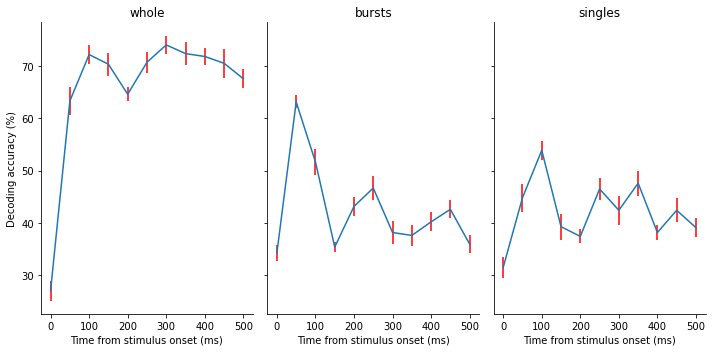

In [10]:
#                                         x   y
matplotlib.rcParams["figure.figsize"] = (10, 5)
unshuffled_cv_accuracy_scores = unshuffled_decoder.cv_accuracy_scores
shuffled_cv_accuracy_scores = shuffled_decoder.cv_accuracy_scores

accuracies = unshuffled_cv_accuracy_scores["whole"]
num_bins = len(accuracies)
bins = np.array(list(range(num_bins)))*50
plot_count = 0
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
for spike_train_type, accuracies in unshuffled_cv_accuracy_scores.items():
    accuracies = dict_to_array(accuracies, CV_COUNT)
    unshuffled_sem = sem(accuracies, axis=1)

    ax[plot_count].errorbar(bins, accuracies.mean(axis=1)*100, unshuffled_sem*100, ecolor='r')#, fmt='none')
    #ax.errorbar(bins,thorough_shuffled_accuracies.mean(axis=1)*100,shuffled_sem*100, ecolor='g')#, fmt='none')
    ax[plot_count].set_xlabel('Time from stimulus onset (ms)')
    ax[plot_count].set_title(spike_train_type)
    plot_count += 1
ax[0].set_ylabel('Decoding accuracy (%)')
#fig.suptitle('Unshuffled Decoder Accuracy (10-Fold Cross Validation)')
fig.tight_layout()
seaborn.despine(fig=fig)
plt.savefig(f"{save_path}/decoding_accuracy.png", dpi=500, facecolor="white", bbox_inches="tight")
plt.show()

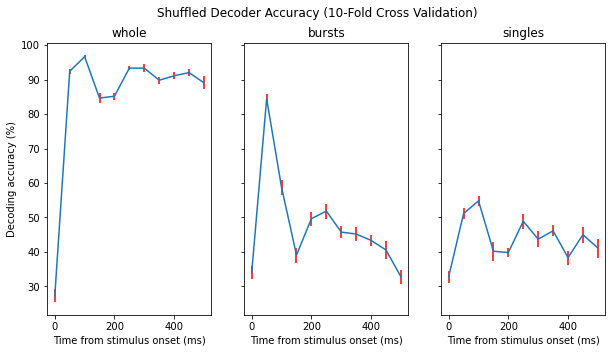

In [8]:
#                                         x   y
matplotlib.rcParams["figure.figsize"] = (10, 5)
shuffled_cv_accuracy_scores = shuffled_decoder.cv_accuracy_scores

accuracies = shuffled_cv_accuracy_scores["whole"]
num_bins = len(accuracies)
bins = np.array(list(range(num_bins)))*50
plot_count = 0
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
for spike_train_type, accuracies in shuffled_cv_accuracy_scores.items():
    accuracies = dict_to_array(accuracies, CV_COUNT)
    unshuffled_sem = sem(accuracies, axis=1)

    ax[plot_count].errorbar(bins, accuracies.mean(axis=1)*100, unshuffled_sem*100, ecolor='r')#, fmt='none')
    #ax.errorbar(bins,thorough_shuffled_accuracies.mean(axis=1)*100,shuffled_sem*100, ecolor='g')#, fmt='none')
    ax[plot_count].set_xlabel('Time from stimulus onset (ms)')
    ax[plot_count].set_title(spike_train_type)
    plot_count += 1
ax[0].set_ylabel('Decoding accuracy (%)')
fig.suptitle('Shuffled Decoder Accuracy (10-Fold Cross Validation)')
plt.show()

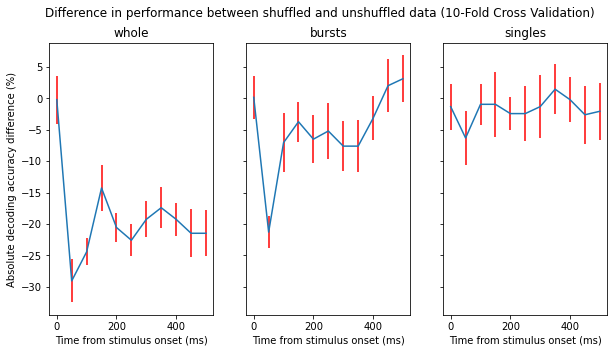

In [9]:
#                                         x   y
matplotlib.rcParams["figure.figsize"] = (10, 5)
unshuffled_cv_accuracy_scores = unshuffled_decoder.cv_accuracy_scores
shuffled_cv_accuracy_scores = shuffled_decoder.cv_accuracy_scores

accuracies = unshuffled_cv_accuracy_scores["whole"]
num_bins = len(accuracies)
bins = np.array(list(range(num_bins)))*50
plot_count = 0
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
for spike_train_type in spike_train_types:
    unshuffled_accuracies = dict_to_array(unshuffled_cv_accuracy_scores[spike_train_type], CV_COUNT)
    shuffled_accuracies = dict_to_array(shuffled_cv_accuracy_scores[spike_train_type], CV_COUNT)
    
    unshuffled_sem = sem(unshuffled_accuracies, axis=1)
    shuffled_sem = sem(shuffled_accuracies, axis=1)

    ax[plot_count].errorbar(bins, unshuffled_accuracies.mean(axis=1)*100 - shuffled_accuracies.mean(axis=1)*100, unshuffled_sem*100 + shuffled_sem*100, ecolor='r')#, fmt='none')
    #ax.errorbar(bins,thorough_shuffled_accuracies.mean(axis=1)*100,shuffled_sem*100, ecolor='g')#, fmt='none')
    ax[plot_count].set_xlabel('Time from stimulus onset (ms)')
    ax[plot_count].set_title(spike_train_type)
    plot_count += 1
ax[0].set_ylabel('Absolute decoding accuracy difference (%)')
fig.suptitle('Difference in performance between shuffled and unshuffled data (10-Fold Cross Validation)')
plt.show()